In [322]:
import h5py
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

from collections import OrderedDict
from operator import itemgetter
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout
from keras.utils import np_utils
from sklearn.metrics import average_precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import time

%matplotlib inline

# Loading data

In [363]:
dataD = scipy.io.loadmat('./DataD.mat')

features = dataD['fea']
labels = dataD['gnd']
labels[labels == -1] = 0
labels = labels.ravel()

print('Succesfully loaded data!')
print("Data D features shape:", features.shape)
print("Labels shape:", labels.shape)

Succesfully loaded data!
Data D features shape: (2200, 57)
Labels shape: (2200,)


# Preprocessing data

In [364]:
features_scaled = scale(features)
half = int(len(features_scaled) / 2)

X_train = features_scaled[:half]
X_test = features_scaled[half:]

y_train = labels[:half]
y_test = labels[half:]

print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Train data shape: (1100, 57)
Test data shape: (1100, 57)


/home/olivier/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


# 1. k-NN

Using 5-fold cross validation
(the crossvalind function can help) on the training set evaluate k-NN on
the values k=[1, 3, 5, 7, ..., 31]. Plot a figure that shows the relationship between
the accuracy and the parameter k. Report the best k in terms of classification accuracy.

In [4]:
kf = KFold(n_splits=5)
k_accuracies = {}

k_neighbors = [i for i in range(1, 32, 2)]
for k in k_neighbors:
    clf = KNeighborsClassifier(n_neighbors=k)
    acc = []
    for train, test in kf.split(X_train):
        clf.fit(X_train[train], y_train[train])
        acc.append(clf.score(X_train[test], y_train[test]))

    accuracy = np.mean(acc)
    k_accuracies[k] = accuracy
    
OrderedDict(sorted(k_accuracies.items(), key=itemgetter(1), reverse=True))

OrderedDict([(7, 0.71545454545454545),
             (11, 0.71181818181818191),
             (13, 0.71090909090909093),
             (9, 0.70909090909090922),
             (15, 0.70363636363636373),
             (1, 0.70181818181818179),
             (5, 0.70181818181818179),
             (17, 0.69999999999999996),
             (3, 0.69727272727272727),
             (19, 0.68818181818181823),
             (21, 0.68818181818181812),
             (23, 0.68636363636363629),
             (25, 0.67727272727272725),
             (31, 0.67636363636363639),
             (27, 0.67454545454545456),
             (29, 0.67363636363636359)])

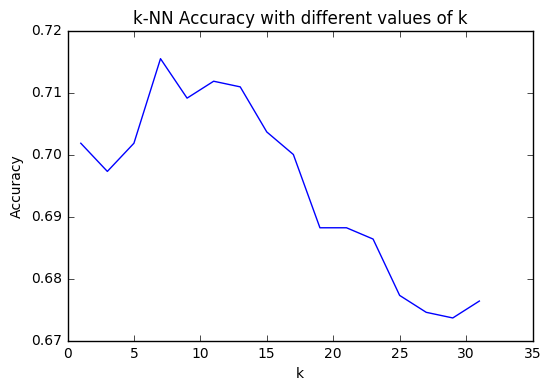

In [7]:
x = list(k_accuracies.values())
y = list(k_accuracies.keys())

plt.plot(y, x)
plt.title('k-NN Accuracy with different values of k')
plt.xlabel('k')
plt.ylabel('Accuracy')

# SVM with RBF kernel

In [116]:
sigmas = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
gamma = [1/(2 * sigma**2) for sigma in sigmas]

parameters = {'kernel':['rbf'], 'C':[0.1, 0.5, 1, 2, 5,10, 20, 50], 'gamma': gamma}
svr = SVC()
clf = GridSearchCV(svr, parameters, cv=5)
clf.fit(X_train, y_train)
print("Best accuracy:", clf.best_score_,  clf.best_params_)

Best accuracy: 0.516363636364 {'C': 2, 'gamma': 2.0, 'kernel': 'rbf'}


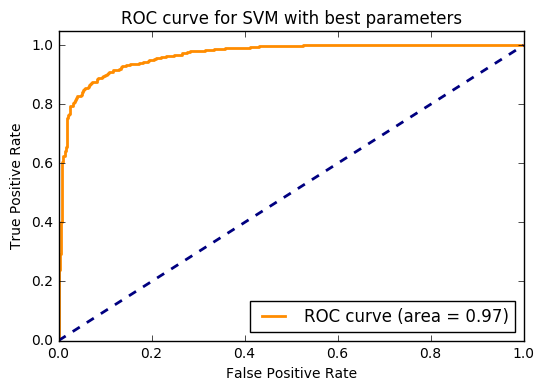

In [23]:
from sklearn.metrics import roc_curve, auc

svm = SVC(kernel='rbf', C=2, gamma=0.02)
svm.fit(X_train, y_train)
y_score = svm.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for SVM with best parameters')
plt.legend(loc="lower right")
plt.show()

## Classifying using the test set with the best parameters

In [141]:
knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(X_train, y_train)
knn_acc = knn.score(X_test, y_test)

svm = SVC(kernel='rbf', C=2, gamma=0.02)
svm.fit(X_train, y_train)
svm_acc = svm.score(X_test, y_test)

print("KNN test accuracy:", knn_acc)
print("SVM test accuracy", svm_acc)

KNN test accuracy: 0.717272727273
SVM test accuracy 0.902727272727


# 3. Decision Trees

In [365]:
clf = tree.DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=1, max_leaf_nodes=(len(X_train) - 1))

clf.fit(X_train, y_train)
dt_acc = clf.score(X_test, y_test)

print("Decision tree test accuracy:", dt_acc)

Decision tree test accuracy: 0.904545454545


# 4. Random Forests

In [51]:
randomforest = RandomForestClassifier(min_samples_split=10, min_samples_leaf=1, max_leaf_nodes=(len(X_train) - 1))

randomforest.fit(X_train, y_train)
dt_acc = randomforest.score(X_test, y_test)
print("Random forest test accuracy:", dt_acc)

Decision tree test accuracy: 0.936363636364


# 5. Neural network

In [356]:
# One-hot encode labels
y_train_onehot = np_utils.to_categorical(y_train)
y_test_onehot = np_utils.to_categorical(y_test)
    
num_features = features.shape[1]
num_classes = len(np.unique(labels))

print(y_train_onehot.shape, y_test_onehot.shape)

model = Sequential()
model.add(Dense(num_features, input_dim=num_features, init='normal', activation='relu'))
model.add(Dense(num_classes, init='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ts = time.time()
model.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot), nb_epoch=100, batch_size=250, verbose=0)
te = time.time()

loss, nn_acc = model.evaluate(X_test, y_test_onehot)

print("\nNeural network accuracy:", nn_acc)
print(te - ts)

(1100, 2) (1100, 2)
1056/1100 [===========================>..] - ETA: 0s
Neural network accuracy: 0.902727272727
7.945659637451172


# 6.1 Gradient Boosted Trees

In [5]:

randomforest = GradientBoostingClassifier()

randomforest.fit(X_train, y_train)
dt_acc = randomforest.score(X_test, y_test)
print("Gradient boosted tree test accuracy:", dt_acc)

Gradient boosted tree test accuracy: 0.971818181818


# 6. Auto-encoder

In [366]:
input_layer = Input(shape=(num_features,))

encoded = Dense(48, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(48, activation='relu')(decoded)
decoded = Dense(num_features, activation='sigmoid')(decoded)

autoencoder = Model(input=input_layer, output=decoded)
encoder = Model(input=input_layer, output=encoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(X_train, X_train,
                nb_epoch=200,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test), verbose=0)

encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)

encoder_input = Input(shape=(16,))
encoded_features = Dense(8, activation='relu')(encoder_input)
#encoded_features = Dropout(0.5)(encoded_features)
encoded_features = Dense(2, activation='softmax')(encoded_features)

encoder_classifier = Model(input=encoder_input, output=encoded_features)

encoder_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

for i in range(5):
    encoder_classifier.fit(encoded_train, y_train_onehot,
                    nb_epoch=100,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(encoded_test, y_test_onehot))

encoder_classifier.evaluate(encoded_test, y_test_onehot)

Train on 1100 samples, validate on 1100 samples
Epoch 1/100
1100/1100 [==============================] - 1s - loss: 7.8497 - acc: 0.4800 - val_loss: 7.6038 - val_acc: 0.4864
Epoch 2/100
1100/1100 [==============================] - 0s - loss: 7.7407 - acc: 0.4800 - val_loss: 7.4493 - val_acc: 0.4864
Epoch 3/100
1100/1100 [==============================] - 0s - loss: 7.6089 - acc: 0.4800 - val_loss: 7.2598 - val_acc: 0.4864
Epoch 4/100
1100/1100 [==============================] - 0s - loss: 7.4064 - acc: 0.4800 - val_loss: 7.0150 - val_acc: 0.4864
Epoch 5/100
1100/1100 [==============================] - 0s - loss: 7.1364 - acc: 0.4809 - val_loss: 6.7112 - val_acc: 0.4864
Epoch 6/100
1100/1100 [==============================] - 0s - loss: 6.8187 - acc: 0.4809 - val_loss: 6.3337 - val_acc: 0.4864
Epoch 7/100
1100/1100 [==============================] - 0s - loss: 6.4112 - acc: 0.4818 - val_loss: 5.8783 - val_acc: 0.4873
Epoch 8/100
1100/1100 [==============================] - 0s - loss: 5.

[0.69881954041394323, 0.50999999978325583]

In [45]:
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)

encoder_input = Input(shape=(16,))
encoded_features = Dense(8, activation='relu')(encoder_input)
encoded_features = Dropout(0.25)(encoded_features)
encoded_features = Dense(2, activation='softmax')(encoded_features)

encoder_classifier = Model(input=encoder_input, output=encoded_features)

encoder_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

encoder_classifier.fit(encoded_train, y_train_onehot,
                nb_epoch=500,
                batch_size=256,
                shuffle=True,
                validation_data=(encoded_test, y_test_onehot))

encoder_classifier.evaluate(encoded_test, y_test_onehot)

Train on 1100 samples, validate on 1100 samples
Epoch 1/500
1100/1100 [==============================] - 0s - loss: 7.1161 - acc: 0.5045 - val_loss: 7.6361 - val_acc: 0.5218
Epoch 2/500
1100/1100 [==============================] - 0s - loss: 7.2594 - acc: 0.4936 - val_loss: 7.6371 - val_acc: 0.5218
Epoch 3/500
1100/1100 [==============================] - 0s - loss: 6.9835 - acc: 0.5064 - val_loss: 7.6329 - val_acc: 0.5218
Epoch 4/500
1100/1100 [==============================] - 0s - loss: 6.9086 - acc: 0.5073 - val_loss: 7.6227 - val_acc: 0.5218
Epoch 5/500
1100/1100 [==============================] - 0s - loss: 6.9132 - acc: 0.5136 - val_loss: 7.6076 - val_acc: 0.5218
Epoch 6/500
1100/1100 [==============================] - 0s - loss: 6.7779 - acc: 0.5145 - val_loss: 7.5855 - val_acc: 0.5218
Epoch 7/500
1100/1100 [==============================] - 0s - loss: 6.8607 - acc: 0.5000 - val_loss: 7.5637 - val_acc: 0.5218
Epoch 8/500
1100/1100 [==============================] - 0s - loss: 6.

[0.46572553634643554, 0.7700000002167442]

In [244]:
results = {}
results['knn'] = {}
results['svm'] = {}
results['dt'] = {}
results['rf'] = {}
results['nn'] = {}
results['gbt'] = {}

for result in results:
    results[result]['accuracy'] = []
    results[result]['precision'] = []
    results[result]['recall'] = []
    results[result]['f'] = []
    results[result]['train_time'] = []
    results[result]['test_time'] = []

classifiers = {
    'knn' : KNeighborsClassifier(n_neighbors=7),
    'svm' : SVC(kernel='rbf', C=2, gamma=0.02, probability=True),
    'dt'  : DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=1, max_leaf_nodes=(len(X_train) - 1)),
    'rf' : RandomForestClassifier(min_samples_split=10, min_samples_leaf=1, max_leaf_nodes=(len(X_train) - 1)),
    'gbt' : GradientBoostingClassifier()
}

for i in range(20):
    idx = np.random.permutation(len(features_scaled))
    features_scaled = features_scaled[idx]
    labels = labels[idx]

    X_train = features_scaled[:half]
    X_test = features_scaled[half:]
    y_train = labels[:half]
    y_test = labels[half:]    
    for clf_name in classifiers:
        clf = classifiers[clf_name]
        
        train_start = time.time()
        clf.fit(X_train, y_train)
        train_end = time.time()
        results[clf_name]['train_time'].append(train_end - train_start)
        
        test_start = time.time()
        clf.predict(X_test)
        test_end = time.time()
        results[clf_name]['test_time'].append(test_end - test_start)     
        
        _, accuracy = cross_val_score(clf, features_scaled, labels, cv=2, scoring='accuracy')
        _, precision = cross_val_score(clf, features_scaled, labels, cv=2, scoring='precision')
        _, recall = cross_val_score(clf, features_scaled, labels, cv=2, scoring='recall')
        _, f = cross_val_score(clf, features_scaled, labels, cv=2, scoring='f1')
        results[clf_name]['accuracy'].append(accuracy)
        results[clf_name]['precision'].append(precision)
        results[clf_name]['recall'].append(recall)
        results[clf_name]['f'].append(f)
        
    y_train_onehot = np_utils.to_categorical(y_train)
    y_test_onehot = np_utils.to_categorical(y_test)
    num_features = features.shape[1]
    num_classes = len(np.unique(labels))
    
    model = Sequential()
    model.add(Dense(num_features, input_dim=num_features, init='normal', activation='relu'))
    model.add(Dense(num_classes, init='normal', activation='softmax'))    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    train_start = time.time()
    model.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot), nb_epoch=100, batch_size=50, verbose=0)
    train_end = time.time()
    
    loss, nn_acc = model.evaluate(X_test, y_test_onehot)
    
    test_start = time.time()
    y_pred = model.predict(X_test)
    test_end = time.time()
    precision = average_precision_score(y_test_onehot, y_pred)
    y_pred = np.argmax(y_pred, axis=1)
    recall = recall_score(y_test, y_pred)    
    f1 = f1_score(y_test, y_pred)    
    
    results['nn']['accuracy'].append(nn_acc)
    results['nn']['precision'].append(precision)
    results['nn']['recall'].append(recall)
    results['nn']['f'].append(f1)
    results['nn']['train_time'].append(train_end - train_start)
    results['nn']['test_time'].append(test_end - test_start)        

{'dt': {'accuracy': [0.93903548680618742,
   0.93721565059144674,
   0.91082802547770703,
   0.93357597816196547,
   0.92538671519563243,
   0.93539581437670605,
   0.91810737033666967,
   0.93812556869881714,
   0.92720655141037311,
   0.92083712465878076,
   0.91264786169244771,
   0.93903548680618742,
   0.93539581437670605,
   0.92447679708826203,
   0.9281164695177434,
   0.92993630573248409,
   0.90627843494085536,
   0.91992720655141036,
   0.93539581437670605,
   0.92993630573248409],
  'f': [0.94336283185840708,
   0.93666369313113296,
   0.91090909090909089,
   0.93950177935943058,
   0.92763731473408895,
   0.92831541218637992,
   0.9229374433363553,
   0.94222222222222218,
   0.93357271095152605,
   0.91771019677996424,
   0.9120580235720761,
   0.94519317160826588,
   0.93511111111111112,
   0.91748003549245782,
   0.92335115864527628,
   0.93511111111111112,
   0.91134751773049638,
   0.92294065544729864,
   0.94468832309043027,
   0.92824704813805625],
  'precision': [0.

In [362]:
for clf_name in results:
    print(clf_name)
    print("Mean")
    print(pd.DataFrame.from_dict(results[clf_name]).mean())
    print("Standard deviation")
    print(pd.DataFrame.from_dict(results[clf_name]).std())

knn
Mean
accuracy      0.735123
f             0.673126
precision     0.926592
recall        0.530810
test_time     0.094852
train_time    0.001424
dtype: float64
Standard deviation
accuracy      0.018119
f             0.034752
precision     0.022454
recall        0.048604
test_time     0.000724
train_time    0.000105
dtype: float64
dt
Mean
accuracy      0.927343
f             0.928918
precision     0.943722
recall        0.918398
test_time     0.000169
train_time    0.004677
dtype: float64
Standard deviation
accuracy      0.009899
f             0.011352
precision     0.010345
recall        0.015234
test_time     0.000051
train_time    0.000335
dtype: float64
gbt
Mean
accuracy      0.966742
f             0.967201
precision     0.986033
recall        0.949120
test_time     0.002126
train_time    0.217476
dtype: float64
Standard deviation
accuracy      0.004273
f             0.004298
precision     0.004448
recall        0.007830
test_time     0.000078
train_time    0.003916
dtype: float64

# Trying autoencoder classification on data D

In [481]:
import tensorflow as tf
import time

# Parameters
learning_rate = 0.01
training_epochs = 100
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
n_hidden_1 = 32 # 1st layer num features
n_hidden_2 = 16 # 2nd layer num features

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_features])
y = tf.placeholder("float", [None, num_classes])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_features, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, num_features])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_features])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

encoded = tf.add(tf.matmul(encoder_op, tf.Variable(tf.random_normal([16, 2]))),
                                       tf.Variable(tf.random_normal([2])))

is_correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(encoded), 1), tf.argmax(y, 1))
encoded_accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
#optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    # Training cycle

    total_batches = int(len(X_train)/batch_size)
    for epoch in range(training_epochs):
        start_time = time.time()
        for i in range(total_batches):
            batch_start = i * batch_size
            batch_xs = X_train[batch_start:batch_start + batch_size]
            batch_ys = y_train_onehot[batch_start:batch_start + batch_size]                 
                 
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs, y: batch_ys})
                 
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")

    # Applying encode and decode over test set
    encode_decode = sess.run(
        encoded_accuracy, feed_dict={X: X_test, y: y_test_onehot})
    print(encode_decode)

Epoch: 0001 cost= 1.336669803
Epoch: 0002 cost= 1.252686620
Epoch: 0003 cost= 1.194153786
Epoch: 0004 cost= 1.153623581
Epoch: 0005 cost= 1.114895344
Epoch: 0006 cost= 1.075670719
Epoch: 0007 cost= 1.042390943
Epoch: 0008 cost= 1.020548820
Epoch: 0009 cost= 1.011955380
Epoch: 0010 cost= 1.009491205
Epoch: 0011 cost= 1.008293152
Epoch: 0012 cost= 1.007159948
Epoch: 0013 cost= 1.005833626
Epoch: 0014 cost= 1.004251361
Epoch: 0015 cost= 1.002456307
Epoch: 0016 cost= 1.000298738
Epoch: 0017 cost= 0.997825623
Epoch: 0018 cost= 0.995283306
Epoch: 0019 cost= 0.992772877
Epoch: 0020 cost= 0.990368605
Epoch: 0021 cost= 0.988036036
Epoch: 0022 cost= 0.985637069
Epoch: 0023 cost= 0.983090162
Epoch: 0024 cost= 0.980468512
Epoch: 0025 cost= 0.977868617
Epoch: 0026 cost= 0.975325406
Epoch: 0027 cost= 0.972688615
Epoch: 0028 cost= 0.970006168
Epoch: 0029 cost= 0.967246771
Epoch: 0030 cost= 0.964479506
Epoch: 0031 cost= 0.961797357
Epoch: 0032 cost= 0.959145308
Epoch: 0033 cost= 0.956584752
Epoch: 003